# Create overview figures
This notebook creates daily overview figures and also shows how to work with the level2 data

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
pwd

'/mnt/lustre02/work/mh0010/m300408/EUREC4A_CloudClassification/manual/EUREC4A_manualclassifications/notebooks'

In [3]:
!ls

Agreement_manual_NN.ipynb      helpers.py
create_overview_figures.ipynb  manual_classifications_timeseries.ipynb
dataset_overview.ipynb	       __pycache__


In [4]:
import sys
sys.path.append("../helpers/")

In [5]:
sys.path.remove('')

In [6]:
sys.path.remove('/mnt/lustre02/work/mh0010/m300408/EUREC4A_CloudClassification/manual/EUREC4A_manualclassifications/notebooks')

In [7]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import os
import tqdm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import dask.array as da
import xarray as xr
import zarr
from helpers import *

In [8]:
mode = 'daily'

# Level1 filename
level1_file = '../processed_data/EUREC4A_ManualClassifications_l1.nc'

# Level2 filename
level2_file = '../processed_data/EUREC4A_ManualClassifications_l2.zarr'.format(mode=mode)

# Level3 filename
level3_file = '../processed_data/EUREC4A_ManualClassifications_l3_VIS_{mode}.zarr'.format(mode=mode)

savefig = False # True: loop through all images and save heatmap, otherwise show first day inline

## Prepare data

In [9]:
# Load level 1 data
ds_l1 = xr.open_dataset(level1_file)
df_l1 = ds_l1.to_dataframe()

In [10]:
# Load level 2 data
if os.path.exists(level2_file):
    # Open file for reading
    ds_l2 = xr.open_zarr(level2_file)
elif os.path.exists(level2_file+'.zip'):
    print('Please unzip {} first an rerun.'.format(level2_file+'.zip'))
    sys.exit()
else:
    print('Run create_level2.py to create the level2 data')

In [11]:
# Load level 3 data
if os.path.exists(level3_file):
    # Open file for reading
    ds_l3 = xr.open_zarr(level3_file)
elif os.path.exists(level3_file+'.zip'):
    print('Please unzip {} first an rerun.'.format(level3_file+'.zip'))
    sys.exit()
else:
    print('Run create_level3.py to create the level3 data')

## Start plotting

### Daily classification frequency based on the workflow EUREC4A (VIS)
Heatmap of all classifications based on MODIS visible images only (GOES16 is ignored here)

In [12]:
ds_l2

<xarray.Dataset>
Dimensions:            (classification_id: 9758, latitude: 1500, longitude: 2200)
Coordinates:
  * classification_id  (classification_id) float64 2.064e+08 ... 2.15e+08
  * latitude           (latitude) float32 20.0 19.99 19.98 ... 5.02 5.01 5.0
  * longitude          (longitude) float32 -62.0 -61.99 -61.98 ... -40.01 -40.0
Data variables:
    mask               (classification_id, longitude, latitude) float64 dask.array<chunksize=(10, 1100, 750), meta=np.ndarray>
Attributes:
    author:          Hauke Schulz (hauke.schulz@mpimet.mpg.de)
    created_on:      2021-11-23 14:25 UTC
    created_with:    create_level2.py with its last modification on Tue Nov 2...
    description:     Level-2: classification masks
    institute:       Max Planck Institut für Meteorologie, Germany
    python_version:  3.8.6 | packaged by conda-forge | (default, Nov 27 2020,...
    title:           EUREC4A: manual meso-scale cloud pattern classifications
    version:         --

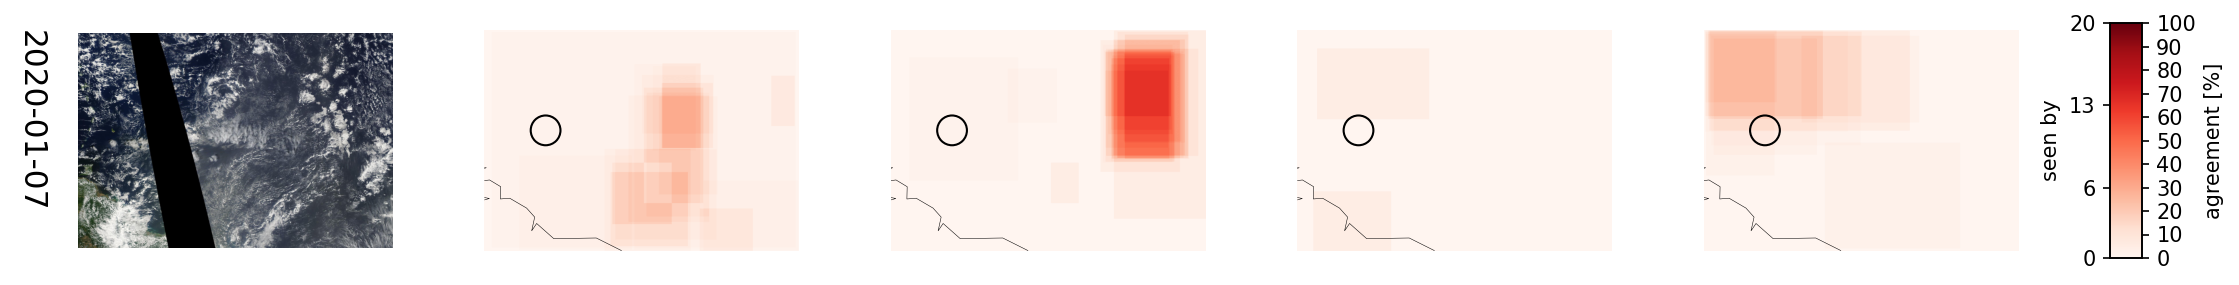

In [14]:
path_to_MODISVIS = '../source_images/EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
instrument = 'MODIS'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_name))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_name))
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] =  user_w_classifications
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)

        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_MODISVIS+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}_{}.jpeg'.format(date.strftime('%Y%m%d'), 'instant'),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

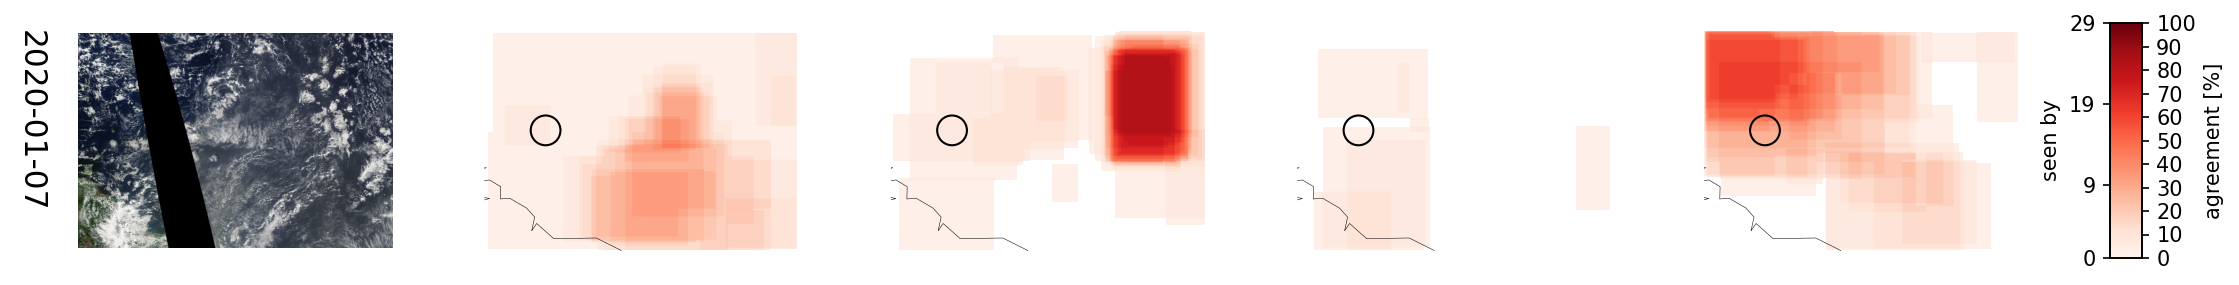

In [15]:
path_to_MODISVIS = '../source_images/EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
instrument = 'MODIS'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((
                         ds_l3.freq.shape[1],
                         ds_l3.freq.shape[2],
                         ds_l3.freq.shape[3]
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] = ds_l3.freq.sel(date=date_as_datetime)
    nb_users = ds_l3.nb_users.sel(date=date_as_datetime).compute()
    user_w_classifications = date_arr*nb_users.values
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
#     norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    norm = Normalize(vmin = 0, vmax = nb_users, clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_MODISVIS+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

### Daily classification frequency based on ICON albedo simulation data

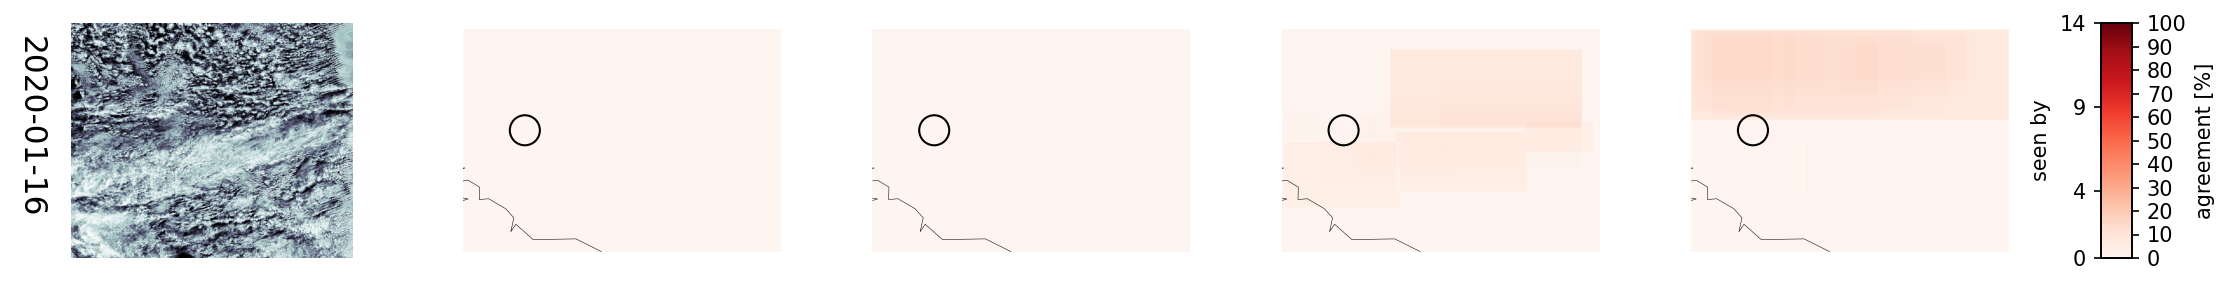

In [17]:
path_to_ICON = '../source_images/EUREC4A_ICON_alb_workflow/'
lons = np.linspace(-62,-44,882)
lats = np.linspace(20,5,735)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (ICON; albedo)'
instrument = 'n/a'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    if d < 9: continue
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_name))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_name))
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] =  user_w_classifications
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, 'ICON_albedo')
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)

        cs = m.imshow(user_w_classifications[:882,:735,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_ICON+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/ICON_alb_dailyaverage/EUREC4A_ManualClassifications_ICONDailyAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

### Daily classification frequency based on the workflow EUREC4A (IR)

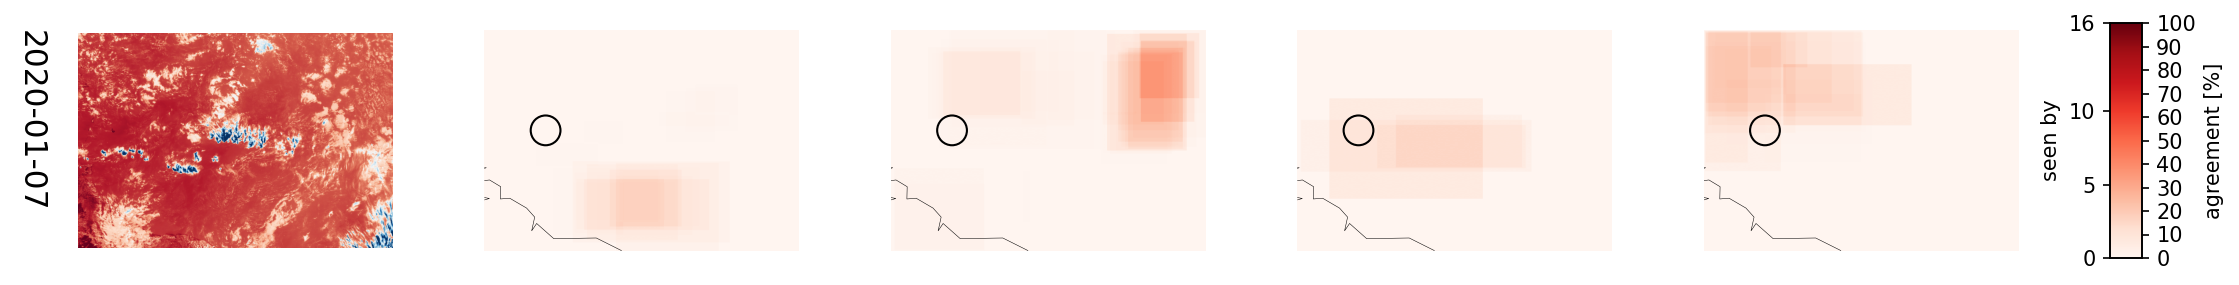

In [18]:
path_to_GOES16 = '../source_images/EUREC4A_IR_workflow/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
instrument = 'ABI'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         ds_l2.mask.shape[1],
                         ds_l2.mask.shape[2],
                         4
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr_ = ds_l2.mask.sel({'classification_id':class_ids})
        user_arr = np.bitwise_and(user_arr_.expand_dims({'pattern':4},3).fillna(0).astype(int).values, np.array([1,2,4,8])[np.newaxis,np.newaxis,np.newaxis,:]).astype('bool')

        user_arr = np.mean(user_arr,axis=0)  # along classification_id

        date_arr[u, :,:,:] = user_arr
    nb_users = len(np.unique(date_df_sel.user_name))

    freq = np.nan_to_num((np.sum(date_arr[:,:,:,:], axis=0)/nb_users))
    user_w_classifications = freq*len(np.unique(date_df_sel.user_name))
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] =  user_w_classifications
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))
    
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1800.jpeg')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})

    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)

    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)

        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show GOES16 ABI image:
    img = plt.imread(path_to_GOES16+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()

    if savefig:
        plt.savefig('../figures/IR_dailyaverage/EUREC4A_ManualClassifications_IRDailyAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

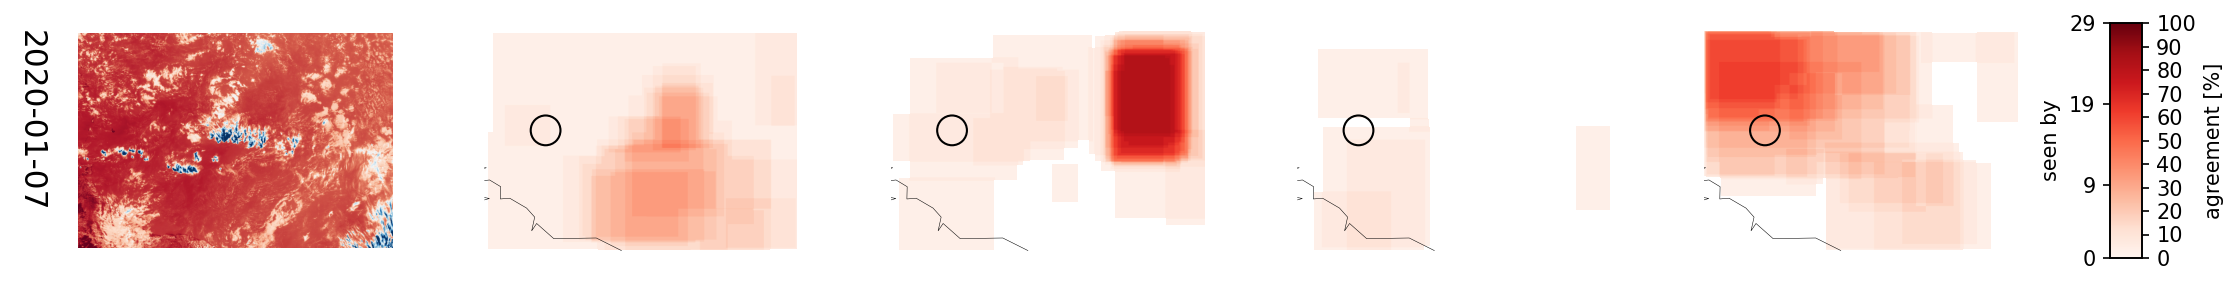

In [19]:
path_to_GOES16 = '../source_images/EUREC4A_IR_workflow/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
instrument = 'ABI'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((
                         ds_l3.freq.shape[1],
                         ds_l3.freq.shape[2],
                         ds_l3.freq.shape[3]
                        ), dtype=float)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    date_as_datetime = dt.datetime.combine(date, dt.datetime.min.time())
    date_arr[:,:,:] = ds_l3.freq.sel(date=date_as_datetime)
    nb_users = ds_l3.nb_users.sel(date=date_as_datetime).compute()
    user_w_classifications = date_arr*nb_users.values
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))
    
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1800.jpeg')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
#     norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    norm = Normalize(vmin = 0, vmax = nb_users, clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(user_w_classifications[:,:,p-1].T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_GOES16+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, nb_users,4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/IR_instant/EUREC4A_ManualClassifications_IR_{}_{}.jpeg'.format('instant', date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break